## Case Study 6 - Analyzing online Job Postings

In [4]:
import pandas as pd 
import numpy as np

import string
import re    #for regex
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

#!pip install textblob
import textblob
from textblob import TextBlob
from textblob import Word

In [5]:
#!pip install wordcloud
from wordcloud import WordCloud

### Import data

In [6]:
job_post = pd.read_csv('E:/data job posts.csv')

In [7]:
job_post.head()

,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,Duration,...,Salary,ApplicationP,OpeningDate,Deadline,Notes,AboutC,Attach,Year,Month,IT
0,AMERIA Investment Consulting Company\nJOB TITL...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"To apply for this position, please submit a\nc...",NaN,26 January 2004,NaN,NaN,NaN,2004,1,False
1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,3 months,...,NaN,Please submit a cover letter and resume to:\nI...,NaN,12 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False
2,Caucasus Environmental NGO Network (CENN)\nJOB...,"Jan 7, 2004",Country Coordinator,Caucasus Environmental NGO Network (CENN),NaN,NaN,NaN,NaN,NaN,Renewable annual contract\nPOSITION,...,NaN,Please send resume or CV toursula.kazarian@......,NaN,20 January 2004\nSTART DATE: February 2004,NaN,The Caucasus Environmental NGO Network is a\nn...,NaN,2004,1,False
3,Manoff Group\nJOB TITLE: BCC Specialist\nPOSI...,"Jan 7, 2004",BCC Specialist,Manoff Group,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Please send cover letter and resume to Amy\nPe...,NaN,23 January 2004\nSTART DATE: Immediate,NaN,NaN,NaN,2004,1,False
4,Yerevan Brandy Company\nJOB TITLE: Software D...,"Jan 10, 2004",Software Developer,Yerevan Brandy Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Successful candidates should submit\n- CV; \n-...,NaN,"20 January 2004, 18:00",NaN,NaN,NaN,2004,1,True


In [8]:
job_post.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19001 entries, 0 to 19000
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   jobpost           19001 non-null  object
 1   date              19001 non-null  object
 2   Title             18973 non-null  object
 3   Company           18994 non-null  object
 4   AnnouncementCode  1208 non-null   object
 5   Term              7676 non-null   object
 6   Eligibility       4930 non-null   object
 7   Audience          640 non-null    object
 8   StartDate         9675 non-null   object
 9   Duration          10798 non-null  object
 10  Location          18969 non-null  object
 11  JobDescription    15109 non-null  object
 12  JobRequirment     16479 non-null  object
 13  RequiredQual      18517 non-null  object
 14  Salary            9622 non-null   object
 15  ApplicationP      18941 non-null  object
 16  OpeningDate       18295 non-null  object
 17  Deadline    

### Job Posting by Year

In [9]:
y = pd.DataFrame(job_post.Year.value_counts().reset_index())
y['Job Posts'] = y.Year
y['Year'] = y['index']
y.drop('index',axis=1,inplace=True)
y.sort_values(by='Year',inplace=True)
y

,Year,Job Posts
11,2004,875
9,2005,1138
10,2006,1116
6,2007,1538
4,2008,1785
8,2009,1191
7,2010,1511
5,2011,1697
0,2012,2149
2,2013,2009


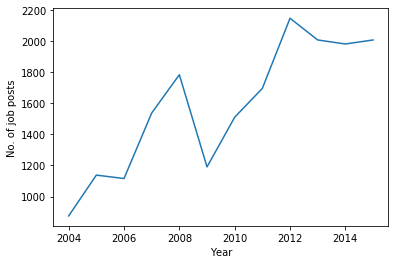

In [10]:
plt.plot('Year','Job Posts',data=y)
plt.xlabel('Year')
plt.ylabel('No. of job posts')
plt.show()

### Job Posting by Month

In [11]:
m = pd.DataFrame(job_post.Month.value_counts().reset_index())
m['Job Posts'] = m.Month
m['Month'] = m['index']
m.drop('index',axis=1,inplace=True)
m.sort_values(by='Month',inplace=True)
m

,Month,Job Posts
11,1,1424
1,2,1665
0,3,1702
9,4,1466
7,5,1580
2,6,1662
6,7,1595
5,8,1613
3,9,1652
4,10,1637


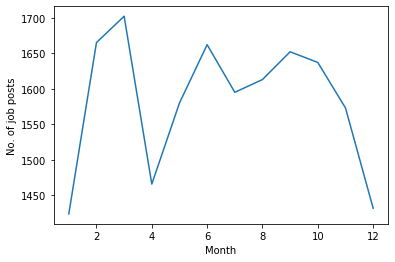

In [12]:
plt.plot('Month','Job Posts',data=m)
plt.xlabel('Month')
plt.ylabel('No. of job posts')
plt.show()

### Top Companies by Job Posting

In [13]:
c = pd.DataFrame(job_post.Company.value_counts().reset_index())
c['Job Posts'] = c.Company
c['Company'] = c['index']
c.drop('index',axis=1,inplace=True)
c.sort_values(by='Job Posts',inplace=True,ascending=False)
c.head(10)

,Company,Job Posts
0,ArmenTel CJSC,353
1,World Vision Armenia,239
2,Mentor Graphics Development Services CJSC,236
3,Career Center NGO,229
4,Orange Armenia,203
5,Ameriabank CJSC,196
6,Converse Bank CJSC,161
7,SAS Group LLC,150
8,UNDP Armenia Office,132
9,Energize Global Services CJSC,126


### Missing Value Treatment

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

In [15]:
class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='mean',filler='NA'):
        self.strategy = strategy
        self.fill = filler

    def fit(self, X, y=None):
        if self.strategy in ['mean','median']:
            if not all(X.dtypes == np.number):
                raise ValueError('dtypes mismatch np.number dtype is \
                                 required for '+ self.strategy)
        if self.strategy == 'mean':
            self.fill = X.mean()
        elif self.strategy == 'median':
            self.fill = X.median()
        elif self.strategy == 'mode':
            self.fill = X.mode().iloc[0]
        elif self.strategy == 'fill':
            if type(self.fill) is list and type(X) is pd.DataFrame:
                self.fill = dict([(cname, v) for cname,v in zip(X.columns, self.fill)])
        return self
    
    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [16]:
job_post = CustomImputer(strategy='mode').fit_transform(job_post)

In [17]:
job_post.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19001 entries, 0 to 19000
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   jobpost           19001 non-null  object
 1   date              19001 non-null  object
 2   Title             19001 non-null  object
 3   Company           19001 non-null  object
 4   AnnouncementCode  19001 non-null  object
 5   Term              19001 non-null  object
 6   Eligibility       19001 non-null  object
 7   Audience          19001 non-null  object
 8   StartDate         19001 non-null  object
 9   Duration          19001 non-null  object
 10  Location          19001 non-null  object
 11  JobDescription    19001 non-null  object
 12  JobRequirment     19001 non-null  object
 13  RequiredQual      19001 non-null  object
 14  Salary            19001 non-null  object
 15  ApplicationP      19001 non-null  object
 16  OpeningDate       19001 non-null  object
 17  Deadline    

### Remove Duplicate Posts

In [18]:
job_post.drop_duplicates(subset=['jobpost','Title'],inplace=True)

In [19]:
job_post.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18892 entries, 0 to 19000
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   jobpost           18892 non-null  object
 1   date              18892 non-null  object
 2   Title             18892 non-null  object
 3   Company           18892 non-null  object
 4   AnnouncementCode  18892 non-null  object
 5   Term              18892 non-null  object
 6   Eligibility       18892 non-null  object
 7   Audience          18892 non-null  object
 8   StartDate         18892 non-null  object
 9   Duration          18892 non-null  object
 10  Location          18892 non-null  object
 11  JobDescription    18892 non-null  object
 12  JobRequirment     18892 non-null  object
 13  RequiredQual      18892 non-null  object
 14  Salary            18892 non-null  object
 15  ApplicationP      18892 non-null  object
 16  OpeningDate       18892 non-null  object
 17  Deadline    

### Data Preparation

In [20]:
job_post = job_post[['jobpost','Title','JobRequirment','JobDescription','RequiredQual','AboutC','Year','IT']]
job_post.head()

,jobpost,Title,JobRequirment,JobDescription,RequiredQual,AboutC,Year,IT
0,AMERIA Investment Consulting Company\nJOB TITL...,Chief Financial Officer,- Supervises financial management and administ...,AMERIA Investment Consulting Company is seekin...,"To perform this job successfully, an\nindividu...",Mentor Graphics Development Services CJSC is a...,2004,False
1,International Research & Exchanges Board (IREX...,Full-time Community Connections Intern (paid i...,- Participate in application design;\n- Provid...,The incumbent will work under the direct super...,- Bachelor's Degree; Master's is preferred;\n-...,The International Research & Exchanges Board (...,2004,False
2,Caucasus Environmental NGO Network (CENN)\nJOB...,Country Coordinator,- Working with the Country Director to provide...,Public outreach and strengthening of a growing...,"- Degree in environmentally related field, or ...",The Caucasus Environmental NGO Network is a\nn...,2004,False
3,Manoff Group\nJOB TITLE: BCC Specialist\nPOSI...,BCC Specialist,- Identify gaps in knowledge and overseeing in...,The LEAD (Local Enhancement and Development fo...,"- Advanced degree in public health, social sci...",Mentor Graphics Development Services CJSC is a...,2004,False
4,Yerevan Brandy Company\nJOB TITLE: Software D...,Software Developer,- Rendering technical assistance to Database M...,The incumbent will work under the direct super...,- University degree; economical background is ...,Mentor Graphics Development Services CJSC is a...,2004,True


In [21]:
text = job_post[['jobpost','Title','JobRequirment','JobDescription','RequiredQual','AboutC']]
text.head()

,jobpost,Title,JobRequirment,JobDescription,RequiredQual,AboutC
0,AMERIA Investment Consulting Company\nJOB TITL...,Chief Financial Officer,- Supervises financial management and administ...,AMERIA Investment Consulting Company is seekin...,"To perform this job successfully, an\nindividu...",Mentor Graphics Development Services CJSC is a...
1,International Research & Exchanges Board (IREX...,Full-time Community Connections Intern (paid i...,- Participate in application design;\n- Provid...,The incumbent will work under the direct super...,- Bachelor's Degree; Master's is preferred;\n-...,The International Research & Exchanges Board (...
2,Caucasus Environmental NGO Network (CENN)\nJOB...,Country Coordinator,- Working with the Country Director to provide...,Public outreach and strengthening of a growing...,"- Degree in environmentally related field, or ...",The Caucasus Environmental NGO Network is a\nn...
3,Manoff Group\nJOB TITLE: BCC Specialist\nPOSI...,BCC Specialist,- Identify gaps in knowledge and overseeing in...,The LEAD (Local Enhancement and Development fo...,"- Advanced degree in public health, social sci...",Mentor Graphics Development Services CJSC is a...
4,Yerevan Brandy Company\nJOB TITLE: Software D...,Software Developer,- Rendering technical assistance to Database M...,The incumbent will work under the direct super...,- University degree; economical background is ...,Mentor Graphics Development Services CJSC is a...


### Remove single lines and quotes

In [22]:
def remove_newline(text):
    text = re.sub(r'\n', '', text)
    text = re.sub(r"\'", '', text)                    
    return(text)

In [23]:
for i in text.columns:
    text[i] = text[i].apply(lambda x: remove_newline(x))

E:\MyPhoto\Analytics\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Remove email, web address and numbers

In [24]:
def remove_emails(text):
    text=re.sub(r'\S+@\S+','', text)
    text=re.sub(r'http://\S+|https://\S+','', text)
    text=re.sub(r'(?:(?:\+?([1-9]|[0-9][0-9]|[0-9][0-9][0-9])\s*(?:[.-]\s*)?)?(?:\(\s*([2-9]1[02-9]|[2-9][02-8]1|[2-9][02-8][02-9])\s*\)|([0-9][1-9]|[0-9]1[02-9]|[2-9][02-8]1|[2-9][02-8][02-9]))\s*(?:[.-]\s*)?)?([2-9]1[02-9]|[2-9][02-9]1|[2-9][02-9]{2})\s*(?:[.-]\s*)?([0-9]{4})(?:\s*(?:#|x\.?|ext\.?|extension)\s*(\d+))?','', text)
    return(text)

In [25]:
for i in text.columns:
    text[i] = text[i].apply(lambda x: remove_emails(x))

E:\MyPhoto\Analytics\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Remove Punctuations

In [26]:
def remove_punctuations(text):
    text=re.sub(r'!"#$%&()*,-./:;<=>?@\[]^_`{|}~','', text)
    text=text.lower()
    return(text)

In [27]:
for i in text.columns:
    text[i] = text[i].apply(lambda x: remove_punctuations(x))

E:\MyPhoto\Analytics\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Tokenization

In [28]:
def tokenization(text):
    text=word_tokenize(text)
    return(text)

In [29]:
token_text = pd.DataFrame()
for i in text.columns:
    token_text[i] = text[i].apply(lambda x: tokenization(x))

In [30]:
token_text.head()

,jobpost,Title,JobRequirment,JobDescription,RequiredQual,AboutC
0,"[ameria, investment, consulting, companyjob, t...","[chief, financial, officer]","[-, supervises, financial, management, and, ad...","[ameria, investment, consulting, company, is, ...","[to, perform, this, job, successfully, ,, anin...","[mentor, graphics, development, services, cjsc..."
1,"[international, research, &, exchanges, board,...","[full-time, community, connections, intern, (,...","[-, participate, in, application, design, ;, -...","[the, incumbent, will, work, under, the, direc...","[-, bachelors, degree, ;, masters, is, preferr...","[the, international, research, &, exchanges, b..."
2,"[caucasus, environmental, ngo, network, (, cen...","[country, coordinator]","[-, working, with, the, country, director, to,...","[public, outreach, and, strengthening, of, a, ...","[-, degree, in, environmentally, related, fiel...","[the, caucasus, environmental, ngo, network, i..."
3,"[manoff, groupjob, title, :, bcc, specialistpo...","[bcc, specialist]","[-, identify, gaps, in, knowledge, and, overse...","[the, lead, (, local, enhancement, and, develo...","[-, advanced, degree, in, public, health, ,, s...","[mentor, graphics, development, services, cjsc..."
4,"[yerevan, brandy, companyjob, title, :, softwa...","[software, developer]","[-, rendering, technical, assistance, to, data...","[the, incumbent, will, work, under, the, direc...","[-, university, degree, ;, economical, backgro...","[mentor, graphics, development, services, cjsc..."


### Lemmatisation

In [31]:
def lemmatisation(text):
    text = text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    return(text)

In [32]:
for i in text.columns:
    text[i] = lemmatisation(text[i])

E:\MyPhoto\Analytics\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Stopwords

In [33]:
stop_words = stopwords.words('english')
stop_words.extend(['armenian','armenia','job','title','position','location','responsibilities','applications',
                   'procedures','deadline','required','qualifications','renumeration','salary','date','company','llc'])

In [34]:
def stop_word_removal(text):
    text = text.apply(lambda x: " ".join(x for x in x.split() if x not in stop_words)) #Removing stop words
    text = text.apply(lambda x: re.sub("  "," ", x))          #Replacing double space with single space
    return(text)

In [35]:
for i in text.columns:
    text[i] = stop_word_removal(text[i])

E:\MyPhoto\Analytics\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
text

,jobpost,Title,JobRequirment,JobDescription,RequiredQual,AboutC
0,ameria investment consulting companyjob title:...,chief financial officer,- supervises financial management administrati...,ameria investment consulting seeking achief fi...,"perform successfully, anindividual must able p...",mentor graphic development service cjsc subsid...
1,international research & exchange board (irex)...,full-time community connection intern (paid in...,- participate application design;- provide nec...,incumbent work direct supervision ofthe presid...,- bachelor degree; master preferred;- excellen...,international research & exchange board (irex)...
2,caucasus environmental ngo network (cenn)job t...,country coordinator,- working country director provide environment...,public outreach strengthening growingnetwork e...,"- degree environmentally related field, 5 year...",caucasus environmental ngo network anon-govern...
3,manoff groupjob title: bcc specialistposition ...,bcc specialist,- identify gap knowledge overseeing informatio...,lead (local enhancement development forhealth)...,"- advanced degree public health, social scienc...",mentor graphic development service cjsc subsid...
4,yerevan brandy companyjob title: software deve...,software developer,- rendering technical assistance database mana...,incumbent work direct supervision ofthe presid...,- university degree; economical background plu...,mentor graphic development service cjsc subsid...
...,...,...,...,...,...,...
18996,technolinguistics ngotitle: senior creative ux...,senior creative ux/ ui designer,- work closely product business team identify ...,tech startup technolinguistics based new yorki...,- least 5 year experience interface/ interacti...,technolinguistics ha mandate transformthe digi...
18997,"""coca-cola hellenic bottling armenia"" cjsctitl...",category development manager,- establish manage category management develop...,incumbent work direct supervision ofthe presid...,"- university degree, ideally business related;...",mentor graphic development service cjsc subsid...
18998,"""coca-cola hellenic bottling armenia"" cjsctitl...",operational marketing manager,"- develop, establish maintain marketing strate...",incumbent work direct supervision ofthe presid...,"- degree business, marketing related field equ...",mentor graphic development service cjsc subsid...
18999,san lazzaro llctitle: head online sale departm...,head online sale department,- handle project activites online store start;...,san lazzaro looking well-experiencedindividual...,- least 1 year experience online sale manageme...,san lazzaro work several international brandsa...


### Test pre-processing on a software developer job post

In [37]:
sd=text[text.Title=='software developer']['jobpost']
frequency_words_wo_stop= {}
for data in sd:
    tokens = nltk.wordpunct_tokenize(data.lower())
    for token in tokens:
        if len(token)>=3:
            if token in frequency_words_wo_stop:
                count = frequency_words_wo_stop[token]
                count = count + 1
                frequency_words_wo_stop[token] = count
            else:
                frequency_words_wo_stop[token] = 1

In [38]:
frequency_words_wo_stop

{'yerevan': 157,
 'brandy': 1,
 'companyjob': 1,
 'title': 11,
 'software': 562,
 'developerposition': 1,
 'location': 8,
 'armeniajob': 139,
 'responsibilities': 94,
 'rendering': 1,
 'technical': 124,
 'assistance': 13,
 'database': 81,
 'management': 37,
 'systems': 50,
 'realization': 1,
 'sql': 123,
 'server': 63,
 'maintenance': 7,
 'activities': 4,
 'back': 3,
 'andreplication': 1,
 'participation': 3,
 'designing': 9,
 'development': 276,
 'projects': 29,
 'required': 145,
 'qualifications': 152,
 'university': 28,
 'degree': 77,
 'economical': 1,
 'background': 19,
 'plus': 59,
 'excellent': 61,
 'knowledge': 429,
 'window': 26,
 '2000': 5,
 'networking': 2,
 'tcp': 3,
 'iptechnologies': 1,
 'visual': 24,
 'basic': 29,
 'least': 79,
 'year': 122,
 'experience': 353,
 'good': 179,
 'english': 122,
 'remuneration': 95,
 'commensurate': 3,
 'norm': 1,
 'accepted': 1,
 'thecompany': 5,
 'application': 389,
 'procedures': 147,
 'successful': 18,
 'candidate': 119,
 'submit': 21,
 '

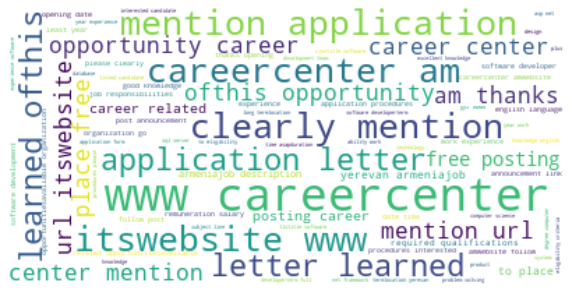

In [39]:
wordcloud = WordCloud(background_color="white").generate(' '.join(sd))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(wordcloud,interpolation='bilinear')

### Supervised Learning

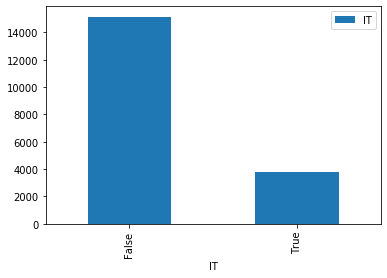

In [40]:
job_post.groupby(['IT']).agg({'IT':'count'}).plot.bar()

### TF - IDF Based Classification

In [41]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD,PCA

In [42]:
vectorizer = TfidfVectorizer()
X_tfidf= vectorizer.fit_transform(text.jobpost)

In [43]:
svd = TruncatedSVD(1500)
X_tfidf = svd.fit_transform(X_tfidf)

In [44]:
print(svd.explained_variance_ratio_.sum())

0.6518890459445524


In [45]:
X_tfidf.shape

(18892, 1500)

### Convert imbalanced data to balanced data by Up-sample minority class

In [49]:
job_post.IT.value_counts()

False    15144
True      3748
Name: IT, dtype: int64

In [52]:
X_tfidf = pd.DataFrame(X_tfidf)
job_post['IT'] = pd.get_dummies(job_post.IT,drop_first=True)
df=pd.concat([X_tfidf,job_post.IT],axis=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1491,1492,1493,1494,1495,1496,1497,1498,1499,IT
0,0.265111,-0.148400,0.215542,0.105730,0.047563,0.134445,-0.098514,0.037277,-0.018541,-0.020492,...,0.010111,-0.008889,-0.006323,-0.007399,0.004694,-0.017621,0.017667,-0.001185,-0.011598,0.0
1,0.171312,-0.045044,-0.030411,0.111070,0.067055,-0.062616,0.057050,-0.043662,-0.006795,0.031014,...,0.007274,-0.004902,0.004971,0.000039,-0.014024,0.004952,0.006141,-0.010911,-0.002553,0.0
2,0.138251,-0.035277,-0.022591,0.082414,0.030945,-0.038122,0.029434,-0.028366,0.001569,0.010429,...,0.014479,0.007297,-0.011029,0.001282,-0.031460,0.023775,0.005326,0.015876,-0.029717,0.0
3,0.168075,0.011567,-0.016534,0.157254,-0.011506,0.009726,0.022473,0.004769,-0.033377,-0.016416,...,0.001139,-0.003705,0.020559,0.003628,-0.004853,0.021098,-0.011018,-0.024807,-0.003752,0.0
4,0.219516,0.090690,0.025965,-0.014483,0.021948,-0.065934,-0.002612,-0.016569,-0.005392,-0.025936,...,0.002751,-0.002798,0.005333,0.011615,-0.005649,0.017847,-0.002487,0.012372,0.001252,1.0


In [53]:
# Separate majority and minority classes
df_majority = df[df.IT==0]
df_minority = df[df.IT==1]

In [55]:
from sklearn.utils import resample

In [56]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, replace=True, n_samples=15144, random_state=123)

In [57]:
# Combine majority class with upsampled minority class
df = pd.concat([df_majority, df_minority_upsampled])

In [58]:
df.IT.value_counts()

1.0    15144
0.0    15144
Name: IT, dtype: int64

In [59]:
#Handling missings
def Missing_imputation(x):
    x = x.fillna(x.median())
    return x

df=df.apply(Missing_imputation)

In [69]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [63]:
X=df.iloc[:,:-1]
y=df.IT

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

print("X_train :",len(X_train))
print("X_test :",len(X_test))
print("Y_train :",len(y_train))
print("Y_test :",len(y_test))

X_train : 21201
X_test : 9087
Y_train : 21201
Y_test : 9087


### SVM

In [64]:
from sklearn.svm import SVC

In [65]:
model = SVC(gamma='scale')

In [66]:
model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [67]:
y_pred= model.predict(X_test)
y_pred

array([1., 1., 0., ..., 1., 0., 0.])

In [71]:
svm=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})

In [72]:
print("Accuracy :")
print(metrics.accuracy_score(svm.Actual,svm.Predicted))

Accuracy :
0.7823264003521514


Text(0.5, 15.0, 'Predicted label')

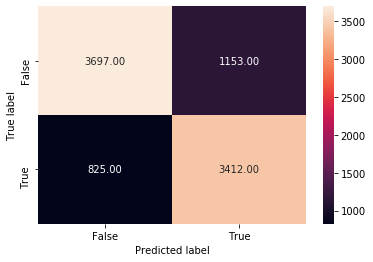

In [73]:
tree_cm = metrics.confusion_matrix(svm.Predicted, svm.Actual, [1,0])

sns.heatmap(tree_cm, annot=True,
         fmt='.2f',
         xticklabels = ["False", "True"] , yticklabels = ["False", "True"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [74]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.75      0.78      4565
         1.0       0.76      0.82      0.79      4522

    accuracy                           0.78      9087
   macro avg       0.78      0.78      0.78      9087
weighted avg       0.78      0.78      0.78      9087



### Un-supervised Learning

#### K-means Clustering

In [81]:
text['RequiredQual_token'] = text['RequiredQual'].astype(str).map(word_tokenize)

E:\MyPhoto\Analytics\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [82]:
vec_tf = CountVectorizer(min_df=2)
required_qual_tf = vec_tf.fit_transform(text['RequiredQual'])
print(required_qual_tf.shape)

(18892, 13298)


In [83]:
required_qual_feature_names = (vec_tf.get_feature_names())
required_qual_feature_names[:10]

['00', '000', '04', '06', '0is', '0program', '0system', '10', '100', '10g']

In [84]:
vec_tfidf = TfidfVectorizer(max_df=0.7, min_df=3, use_idf=True)
required_qual_tfidf = vec_tfidf.fit_transform(text['RequiredQual'])
print(required_qual_tfidf.shape)

(18892, 9808)


In [86]:
import pickle

In [87]:
pickle.dump(required_qual_tfidf, open("required_qual_tfidf.pkl", "wb"))
pickle.dump(vec_tfidf.vocabulary_, open("required_qual_tfidf_features.pkl", "wb"))

In [91]:
from sklearn.preprocessing import normalize,Normalizer
from sklearn.pipeline import make_pipeline

In [92]:
# Use SVD to reduce dimensions
svd = TruncatedSVD(1500)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X_lsa = lsa.fit_transform(required_qual_tfidf)

In [93]:
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Explained variance of the SVD step: 82%


In [94]:
range_n_clusters = list (range(4,11))

In [96]:
from sklearn.cluster import KMeans

In [98]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score,pairwise_distances

In [99]:
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(X_lsa)
    centers = clusterer.cluster_centers_

    score = silhouette_score(X_lsa, preds, metric='euclidean')
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

For n_clusters = 4, silhouette score is 0.02871606049489046
For n_clusters = 5, silhouette score is 0.030202972084703596
For n_clusters = 6, silhouette score is 0.03096549460300552
For n_clusters = 7, silhouette score is 0.030937856354146222
For n_clusters = 8, silhouette score is 0.03280679614831819
For n_clusters = 9, silhouette score is 0.03317151172440164
For n_clusters = 10, silhouette score is 0.033457686968800825


##### We will select 9 clusters due to high silhouette score

In [100]:
num_clusters = 9

for num in [num_clusters]:
    km3 = KMeans(n_clusters=num, init='k-means++', max_iter=1000, n_init=1, random_state=1)
    %time km3.fit(X_lsa)
    print("Clusters: {0}".format(num))
    print("Silhouette Coefficient for clusters: %0.3f"
          % metrics.silhouette_score(X_lsa, km3.labels_))

Wall time: 7.11 s
Clusters: 9
Silhouette Coefficient for clusters: 0.032


In [101]:
def print_terms(cm, num):
    original_space_centroids = svd.inverse_transform(cm.cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    terms = vec_tfidf.get_feature_names()
    for i in range(num):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

print_terms(km3, num_clusters)

Cluster 0: ability work degree skills management skill year excellent language good
Cluster 1: driving license medical work medicine russian skills pharmaceutical education valid
Cluster 2: accounting finance tax work software excellent good year degree financial
Cluster 3: development good ability programming language design software web java work
Cluster 4: higher education work russian languages excellent skills field good computer
Cluster 5: skills excellent work ability russian languages communication university degree strong
Cluster 6: banking bank skills economics legislation financial finance work year good
Cluster 7: net asp sql framework web good server development work design
Cluster 8: confident communicative timely punctual eager minded complete open manner mail


### Topic Modelling to determine nature of Jobs over time

In [ ]:
#!pip install spacy

In [108]:
import spacy
from spacy import displacy
from spacy.matcher import Matcher

In [116]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [106]:
text['jobpost_token'] = text.jobpost.map(word_tokenize)

In [117]:
def pos_tag(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [118]:
text['jobpost_processed'] = pos_tag(text.jobpost_token, allowed_postags=['NOUN', 'VERB'])

In [119]:
text.jobpost_processed

0        [title, officerposition, location, description...
1        [title, time, community, connection, intern, p...
2        [cenn, job, title, country, coordinatorpositio...
3        [description, lead, enhancement, development, ...
4        [title, software, developerposition, location,...
                               ...                        
18996    [ux/, timeduration, termlocation, description,...
18997    [bottling, cjsctitle, category, development, m...
18998    [bottling, cjsctitle, marketing, managerterm, ...
18999    [head, sale, departmentduration, termlocation,...
19000    [cjsctitle, lawyer, departmentterm, timedurati...
Name: jobpost_processed, Length: 18892, dtype: object

In [125]:
import gensim 
from gensim.models.doc2vec import Doc2Vec
from operator import itemgetter
from gensim import corpora

In [126]:
dictionary = corpora.Dictionary(text.jobpost_processed)
dictionary.filter_extremes(no_below=3, no_above=0.7)

In [127]:
dtm_train = [dictionary.doc2bow(d) for d in text.jobpost_processed]
lda = gensim.models.ldamodel.LdaModel(dtm_train,num_topics=7,alpha='auto',chunksize=30,id2word=dictionary,passes=20)
dtopics_train = lda.get_document_topics(dtm_train)

In [128]:
lda.show_topics()

[(0,
  '0.023*"accounting" + 0.022*"report" + 0.019*"prepare" + 0.019*"community" + 0.019*"finance" + 0.015*"child" + 0.014*"ensure" + 0.014*"education" + 0.013*"bank" + 0.013*"tax"'),
 (1,
  '0.037*"customer" + 0.031*"business" + 0.029*"marketing" + 0.029*"sale" + 0.026*"line" + 0.021*"market" + 0.019*"product" + 0.019*"develop" + 0.014*"look" + 0.014*"communication"'),
 (2,
  '0.104*"criterion" + 0.098*"eligibility" + 0.043*"timeopen" + 0.040*"to/" + 0.031*"candidates.start" + 0.016*"driver" + 0.016*"roam" + 0.015*"conflict" + 0.014*"shift" + 0.013*"vivacell"'),
 (3,
  '0.052*"design" + 0.047*"software" + 0.045*"development" + 0.032*"test" + 0.029*"web" + 0.029*"team" + 0.026*"develop" + 0.019*"developer" + 0.018*"code" + 0.016*"testing"'),
 (4,
  '0.029*"language" + 0.016*"form" + 0.015*"course" + 0.015*"office" + 0.011*"fill" + 0.011*"applicant" + 0.011*"website" + 0.009*"note" + 0.009*"write" + 0.009*"time"'),
 (5,
  '0.032*"candidate" + 0.029*"ability" + 0.028*"language" + 0.024*

In [129]:
pd.DataFrame({'Topic':[0,1,2,3,4,5,6],
             'Nature of Job':['Project Development','Website','Language Training','Language Coordinator','Communication',
                              'Software Development','Bank accounting and finance']})

,Topic,Nature of Job
0,0,Project Development
1,1,Website
2,2,Language Training
3,3,Language Coordinator
4,4,Communication
5,5,Software Development
6,6,Bank accounting and finance


In [130]:
top_train = [max(t, key=itemgetter(1))[0] for t in dtopics_train]

Text(0.5, 1.0, 'Topic Frequencies')

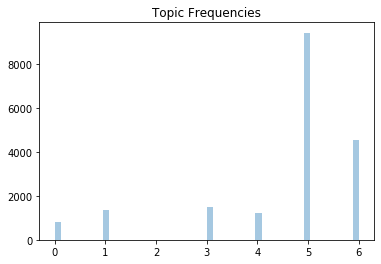

In [131]:
sns.distplot(top_train, kde=False).set_title('Topic Frequencies')

In [132]:
dictionary.save('dictionary.dict')

In [133]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in text.jobpost_processed]
corpora.MmCorpus.serialize('corpus.mm', doc_term_matrix)

In [134]:
lda.save('topic.model')

In [135]:
dictionary = gensim.corpora.Dictionary.load('dictionary.dict')
corpus = gensim.corpora.MmCorpus('corpus.mm')
lda = gensim.models.LdaModel.load('topic.model')

### Observing the changes in Topics over the years

In [136]:
topics = pd.Series(top_train)
text['topic'] = topics.values
text = pd.DataFrame(text)

In [138]:
df=pd.concat([text.topic,job_post.Year],axis=1)
df.head()

,topic,Year
0,6,2004
1,4,2004
2,6,2004
3,6,2004
4,5,2004


Text(0.5, 1.0, 'Topic Frequencies 2004 - 2007')

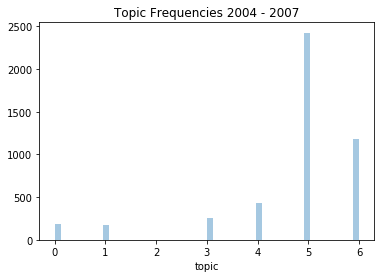

In [139]:
# For 2004 - 2007
df_04to07 = df[df.Year <= 2007]
sns.distplot(df_04to07['topic'], kde=False).set_title('Topic Frequencies 2004 - 2007')

Text(0.5, 1.0, 'Topic Frequencies 2008 - 2011')

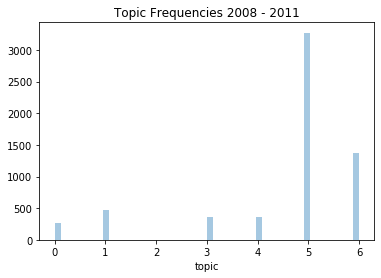

In [140]:
# For 2008 - 2011
df_08to11 = df[(df['Year'] > 2007) & (df['Year'] <= 2011)]
sns.distplot(df_08to11['topic'], kde=False).set_title('Topic Frequencies 2008 - 2011')

Text(0.5, 1.0, 'Topic Frequencies 2012 - 2015')

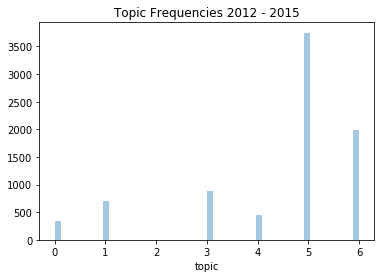

In [141]:
# For 2012 - 2015
df_12to15 = df[(df['Year'] > 2011) & (df['Year'] <= 2015)]
sns.distplot(df_12to15['topic'], kde=False).set_title('Topic Frequencies 2012 - 2015')

### Information Extraction

#### Information Extraction to obtain company profiles

In [142]:
text['AboutC'].head()

0    mentor graphic development service cjsc subsid...
1    international research & exchange board (irex)...
2    caucasus environmental ngo network anon-govern...
3    mentor graphic development service cjsc subsid...
4    mentor graphic development service cjsc subsid...
Name: AboutC, dtype: object

In [144]:
matcher = Matcher(nlp.vocab)

In [145]:
def collect_sents(matcher, doc, i, matches):
    match_id, start, end = matches[i]
    span = doc[start : end]  # matched span
    sent = span.sent  # sentence containing matched span
    match_ents = [{'start': span.start_char - sent.start_char,
                   'end': span.end_char - sent.start_char,
                   'label': 'MATCH'}]
    matched_sents.append({'text': sent.text, 'ents': match_ents })

In [147]:
pattern1 = [{'POS':'ADJ'},{'ORTH': '-'}, {'POS':'NOUN', 'OP':'+'}, {'LOWER': 'organization'}]
pattern2 = [{'POS':'NOUN', 'OP':'+'}, {'LOWER': 'organization'}]
pattern3 = [{'POS':'NOUN', 'OP':'+'}, {'LOWER': 'company'}]
pattern4 = [{'POS':'NOUN', 'OP':'+'}, {'LOWER': 'services'}]
pattern5 = [{'LOWER': 'company'}, {'POS':'VERB'}, {'POS':'NOUN', 'OP':'+'}]
pattern6 = [{'LOWER':'provider'}, {'POS':'ADP'}, {'POS':'NOUN',  'OP': '+'}  , {'POS':'CCONJ','OP':'+'}, {'POS':'NOUN','OP':'+'}]
pattern7 = [{'LOWER':'provider'}, {'POS':'ADP'}, {'POS':'NOUN',  'OP': '+'}]
pattern8 = [{'POS':'VERB'}, {'POS':'NOUN',  'OP': '+'} ]
pattern9 = [{'POS':'ADJ'}, {'POS':'NOUN',  'OP': '+'} ]
pattern10 = [{'POS':'NOUN'}, {'POS':'ADP'}, {'POS':'NOUN',  'OP': '+'} ]
pattern11 = [{'POS':'NOUN'}, {'POS':'NOUN','OP':'+'} ]

In [148]:
matcher.add('all', collect_sents, pattern1, pattern2, pattern3, pattern4, pattern5, pattern6, pattern7, pattern8, 
            pattern9, pattern10, pattern11)

In [ ]:
matched_sents=[]
for t in text.AboutC:
    if pd.notnull(t) and t != 'NaN':
        t = re.sub(r'\s+', ' ', t)
        doc = nlp(t)
        matches = matcher(doc)
        token_set = []
        for match_id, start, end in matches:
            string_id = nlp.vocab.strings[match_id]  # get string representation
            span = doc[start:end]  # the matched span
            token_set.append(span.text)    
        matched_sents.append(token_set)

In [150]:
flat_list = []
for row in matched_sents:
    for token in row:
        flat_list.append(token)

In [ ]:
plt.figure(figsize=(20, 9))
fd = nltk.FreqDist(flat_list)  # case sensitive!
fd.most_common(50)
fd.plot(50)

### Job Similarity

In [152]:
text['JobDescription_token'] = text['JobDescription'].map(word_tokenize)
text['RequiredQual_token'] = text['RequiredQual'].map(word_tokenize)
text['JobRequirment_token'] = text['JobRequirment'].map(word_tokenize)

In [153]:
tfidf_model = TfidfVectorizer()
Title_tfidf = tfidf_model.fit_transform(text['Title'])
JobDescription_tfidf = tfidf_model.fit_transform(text['JobDescription'])
RequiredQual_tfidf = tfidf_model.fit_transform(text['RequiredQual'])
JobRequirment_tfidf = tfidf_model.fit_transform(text['JobRequirment'])

In [154]:
from sklearn.metrics.pairwise import cosine_similarity

In [155]:
def find_similar_jobs_tfidf(index, top_n = 5):
    Title_tfidf_cosine = cosine_similarity(Title_tfidf[index:index+1], Title_tfidf).flatten()
    JobDescription_tfidf_cosine = cosine_similarity(JobDescription_tfidf[index:index+1], JobDescription_tfidf).flatten()
    RequiredQual_tfidf_cosine = cosine_similarity(RequiredQual_tfidf[index:index+1], RequiredQual_tfidf).flatten()
    JobRequirment_tfidf_cosine = cosine_similarity(JobRequirment_tfidf[index:index+1], JobRequirment_tfidf).flatten()

    average_cosine = (Title_tfidf_cosine +JobDescription_tfidf_cosine+RequiredQual_tfidf_cosine+JobRequirment_tfidf_cosine)/4.0
    related_docs_indices = [i for i in average_cosine.argsort()[::-1] if i != index]
    return [(index, average_cosine[index]) for index in related_docs_indices][0:top_n]

### Chief Financial Officer Jobs

In [156]:
text.iloc[0]

jobpost                 ameria investment consulting companyjob title:...
Title                                             chief financial officer
JobRequirment           - supervises financial management administrati...
JobDescription          ameria investment consulting seeking achief fi...
RequiredQual            perform successfully, anindividual must able p...
AboutC                  mentor graphic development service cjsc subsid...
RequiredQual_token      [perform, successfully, ,, anindividual, must,...
jobpost_token           [ameria, investment, consulting, companyjob, t...
jobpost_processed       [title, officerposition, location, description...
topic                                                                   6
JobDescription_token    [ameria, investment, consulting, seeking, achi...
JobRequirment_token     [-, supervises, financial, management, adminis...
Name: 0, dtype: object

In [157]:
for index, score in find_similar_jobs_tfidf(0):
    print(text.iloc[index])
    print("SIMILARITY SCORE: ", score)

jobpost                 "gritti" llctitle: chief financial officerterm...
Title                                             chief financial officer
JobRequirment           general responsibilities: - assist performing ...
JobDescription          gritti inviting highly qualifiedprofessionals ...
RequiredQual            - master equivalent university degree finance ...
AboutC                  gritti franchisee stefano ricci andother fashi...
RequiredQual_token      [-, master, equivalent, university, degree, fi...
jobpost_token           [``, gritti, '', llctitle, :, chief, financial...
jobpost_processed       [gritti, llctitle, officerterm, timestart, dat...
topic                                                                   6
JobDescription_token    [gritti, inviting, highly, qualifiedprofession...
JobRequirment_token     [general, responsibilities, :, -, assist, perf...
Name: 8120, dtype: object
SIMILARITY SCORE:  0.38595423509717625
jobpost                 river islandtitle: chie

### Intern Jobs

In [158]:
text.iloc[1]

jobpost                 international research & exchange board (irex)...
Title                   full-time community connection intern (paid in...
JobRequirment           - participate application design;- provide nec...
JobDescription          incumbent work direct supervision ofthe presid...
RequiredQual            - bachelor degree; master preferred;- excellen...
AboutC                  international research & exchange board (irex)...
RequiredQual_token      [-, bachelor, degree, ;, master, preferred, ;,...
jobpost_token           [international, research, &, exchange, board, ...
jobpost_processed       [title, time, community, connection, intern, p...
topic                                                                   4
JobDescription_token    [incumbent, work, direct, supervision, ofthe, ...
JobRequirment_token     [-, participate, application, design, ;, -, pr...
Name: 1, dtype: object

In [159]:
for index, score in find_similar_jobs_tfidf(1):
    print(text.iloc[index])
    print("SIMILARITY SCORE: ", score)

jobpost                 international research & exchange board (irex)...
Title                       non-paid part full time administrative intern
JobRequirment           - participate application design;- provide nec...
JobDescription          incumbent work direct supervision ofthe presid...
RequiredQual            - excellent communication skills;- good oral w...
AboutC                  international research & exchange board (irex)...
RequiredQual_token      [-, excellent, communication, skills, ;, -, go...
jobpost_token           [international, research, &, exchange, board, ...
jobpost_processed       [title, pay, part, time, internduration, month...
topic                                                                   4
JobDescription_token    [incumbent, work, direct, supervision, ofthe, ...
JobRequirment_token     [-, participate, application, design, ;, -, pr...
Name: 11, dtype: object
SIMILARITY SCORE:  0.6698631101160858
jobpost                 military institute mod raj

### Country Coordinator

In [160]:
text.iloc[2]

jobpost                 caucasus environmental ngo network (cenn)job t...
Title                                                 country coordinator
JobRequirment           - working country director provide environment...
JobDescription          public outreach strengthening growingnetwork e...
RequiredQual            - degree environmentally related field, 5 year...
AboutC                  caucasus environmental ngo network anon-govern...
RequiredQual_token      [-, degree, environmentally, related, field, ,...
jobpost_token           [caucasus, environmental, ngo, network, (, cen...
jobpost_processed       [cenn, job, title, country, coordinatorpositio...
topic                                                                   6
JobDescription_token    [public, outreach, strengthening, growingnetwo...
JobRequirment_token     [-, working, country, director, provide, envir...
Name: 2, dtype: object

In [161]:
for index, score in find_similar_jobs_tfidf(2):
    print(text.iloc[index])
    print("SIMILARITY SCORE: ", score)

jobpost                 caucasus environmental ngo networktitle: count...
Title                                               country coordinator -
JobRequirment           - write first hand articles, conduct interview...
JobDescription          cenn - caucasus environmental ngo network - lo...
RequiredQual            1. education: university education environment...
AboutC                  caucasus environmental ngo network anon-govern...
RequiredQual_token      [1., education, :, university, education, envi...
jobpost_token           [caucasus, environmental, ngo, networktitle, :...
jobpost_processed       [country, coordinator, armeniaannouncement, co...
topic                                                                   6
JobDescription_token    [cenn, -, caucasus, environmental, ngo, networ...
JobRequirment_token     [-, write, first, hand, articles, ,, conduct, ...
Name: 404, dtype: object
SIMILARITY SCORE:  0.43129875823884634
jobpost                 veya limitedtitle: count

### Using Pretrained Word2Vec Embedding

In [162]:
doc1 = nlp(text.iloc[0]['Title'])
doc2 = nlp(text.iloc[2]['Title'])
similarity = doc1.similarity(doc2)
print("DOC1:\n" + doc1.text, "\n\nDOC2:\n", doc2.text, "\n\n", similarity)

E:\MyPhoto\Analytics\lib\site-packages\ipykernel_launcher.py:3: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  This is separate from the ipykernel package so we can avoid doing imports until


DOC1:
chief financial officer 

DOC2:
 country coordinator 

 0.5329448254832846


In [163]:
# Original text - RequiredQual
doc1 = nlp(text.iloc[0]['RequiredQual'])
doc2 = nlp(text.iloc[2]['RequiredQual'])
similarity = doc1.similarity(doc2)
print("DOC1:\n" + doc1.text, "\n\nDOC2:\n", doc2.text, "\n\n", similarity)

DOC1:
perform successfully, anindividual must able perform essential duty satisfactorily.the requirement listed representative knowledge,skill, and/or ability required.knowledge of:- generally accepted accounting principles;- local accounting standard legislation;- state reporting requirement pertaining accounting;- principle practice financial management budgeting;- principle practice financial system design analysis;- principle practice contract management, record management,and risk management;- principle practice management supervision;- principle practice information system management.ability to:- apply sound fiscal administrative practice companysactivities;- plan, organize supervise work subordinate employees,including training them, assigning evaluating work, andproviding performance feedback;- critically analyze fiscal administrative policies, practices,procedures, systems, recommend implement change needed;- gather synthesize financial information variety sourcesand present v

E:\MyPhoto\Analytics\lib\site-packages\ipykernel_launcher.py:3: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  This is separate from the ipykernel package so we can avoid doing imports until


In [164]:
# removing stopwords and punctuations
doc1 = nlp(' '.join(text.iloc[0]['RequiredQual_token']))
doc2 = nlp(' '.join(text.iloc[2]['RequiredQual_token']))
similarity = doc1.similarity(doc2)
print("DOC1:\n" + doc1.text, "\n\nDOC2:\n", doc2.text, "\n\n", similarity)

DOC1:
perform successfully , anindividual must able perform essential duty satisfactorily.the requirement listed representative knowledge , skill , and/or ability required.knowledge of : - generally accepted accounting principles ; - local accounting standard legislation ; - state reporting requirement pertaining accounting ; - principle practice financial management budgeting ; - principle practice financial system design analysis ; - principle practice contract management , record management , and risk management ; - principle practice management supervision ; - principle practice information system management.ability to : - apply sound fiscal administrative practice companysactivities ; - plan , organize supervise work subordinate employees , including training them , assigning evaluating work , andproviding performance feedback ; - critically analyze fiscal administrative policies , practices , procedures , systems , recommend implement change needed ; - gather synthesize financial

E:\MyPhoto\Analytics\lib\site-packages\ipykernel_launcher.py:4: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  after removing the cwd from sys.path.
